# Training and comparison of multiple ML models for fraud detection

In [4]:
# ============================================================================
# 1. SETUP AND LOAD PREPROCESSED DATA
# ============================================================================

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
import time
from collections import Counter

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import IsolationForest
import xgboost as xgb
import lightgbm as lgb

# Model Selection and Evaluation
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                           roc_curve, precision_recall_curve, average_precision_score,
                           precision_score, recall_score, f1_score, accuracy_score)

# Visualization
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay


# Configuration
warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")

print("=== Credit Card Fraud Detection - Machine Learning Models ===")
print("Libraries imported successfully!")

# Load preprocessed data
print("\nLoading preprocessed data...")
try:
    with open('/content/preprocessed_data.pkl', 'rb') as f:
        data = pickle.load(f)

    X_train = data['X_train']
    y_train = data['y_train']
    X_val = data['X_val']
    y_val = data['y_val']
    X_test = data['X_test']
    y_test = data['y_test']
    feature_names = data['feature_names']

    print("✓ Preprocessed data loaded successfully!")

except FileNotFoundError:
    print(" Error: preprocessed_data.pkl not found!")
    print("Please upload the pickle file from preprocessing notebook.")

# Verify data integrity
print(f"\nData shapes:")
print(f"• X_train: {X_train.shape}")
print(f"• X_val: {X_val.shape}")
print(f"• X_test: {X_test.shape}")
print(f"• Features: {feature_names}")

print(f"\nClass distributions:")
print(f"• Train: {Counter(y_train)}")
print(f"• Validation: {Counter(y_val)}")
print(f"• Test: {Counter(y_test)}")

=== Credit Card Fraud Detection - Machine Learning Models ===
Libraries imported successfully!

Loading preprocessed data...
✓ Preprocessed data loaded successfully!

Data shapes:
• X_train: (238068, 10)
• X_val: (42446, 10)
• X_test: (42559, 10)
• Features: ['V17', 'V14', 'V3', 'V10', 'V12', 'V16', 'V7', 'V11', 'V4', 'V18']

Class distributions:
• Train: Counter({0: 198390, 1: 39678})
• Validation: Counter({0: 42375, 1: 71})
• Test: Counter({0: 42488, 1: 71})


In [5]:
# ============================================================================
# 2. MODEL EVALUATION FRAMEWORK
# ============================================================================

print("\n" + "="*60)
print("MODEL EVALUATION FRAMEWORK SETUP")
print("="*60)

def evaluate_model(model, X_train, y_train, X_val, y_val, model_name="Model"):
    """
    Comprehensive model evaluation function
    """
    # Training
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time

    # Predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    # Probabilities (if available)
    try:
        y_train_proba = model.predict_proba(X_train)[:, 1]
        y_val_proba = model.predict_proba(X_val)[:, 1]
    except:
        y_train_proba = model.decision_function(X_train)
        y_val_proba = model.decision_function(X_val)

    # Metrics calculation
    metrics = {
        'model_name': model_name,
        'training_time': training_time,

        # Training metrics
        'train_accuracy': accuracy_score(y_train, y_train_pred),
        'train_precision': precision_score(y_train, y_train_pred),
        'train_recall': recall_score(y_train, y_train_pred),
        'train_f1': f1_score(y_train, y_train_pred),
        'train_roc_auc': roc_auc_score(y_train, y_train_proba),

        # Validation metrics
        'val_accuracy': accuracy_score(y_val, y_val_pred),
        'val_precision': precision_score(y_val, y_val_pred),
        'val_recall': recall_score(y_val, y_val_pred),
        'val_f1': f1_score(y_val, y_val_pred),
        'val_roc_auc': roc_auc_score(y_val, y_val_proba),
        'val_avg_precision': average_precision_score(y_val, y_val_proba)
    }

    return metrics, model, y_val_pred, y_val_proba

def plot_model_comparison(results_df):
    """
    Plot comparison of model performance
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    metrics_to_plot = ['val_precision', 'val_recall', 'val_f1', 'val_roc_auc', 'val_avg_precision', 'training_time']
    titles = ['Validation Precision', 'Validation Recall', 'Validation F1-Score',
              'Validation ROC-AUC', 'Validation Avg Precision', 'Training Time (s)']

    for i, (metric, title) in enumerate(zip(metrics_to_plot, titles)):
        ax = axes[i//3, i%3]

        bars = ax.bar(results_df['model_name'], results_df[metric],
                     color=plt.cm.Set3(np.linspace(0, 1, len(results_df))))

        ax.set_title(title, fontweight='bold', fontsize=12)
        ax.set_ylabel(metric.replace('val_', '').replace('_', ' ').title())

        # Rotate x-axis labels for better readability
        ax.tick_params(axis='x', rotation=45)

        # Add value labels on bars
        for bar, value in zip(bars, results_df[metric]):
            if metric == 'training_time':
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                       f'{value:.2f}s', ha='center', va='bottom', fontsize=10)
            else:
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                       f'{value:.3f}', ha='center', va='bottom', fontsize=10)

        ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

print("✓ Evaluation framework ready!")


MODEL EVALUATION FRAMEWORK SETUP
✓ Evaluation framework ready!



BASELINE MODELS TRAINING
Training baseline models...

Training Logistic Regression...
✓ Logistic Regression completed - Val F1: 0.3096, ROC-AUC: 0.9752

Training Decision Tree...
✓ Decision Tree completed - Val F1: 0.2742, ROC-AUC: 0.9392

Training Random Forest...
✓ Random Forest completed - Val F1: 0.7733, ROC-AUC: 0.9665

Training Gradient Boosting...
✓ Gradient Boosting completed - Val F1: 0.5210, ROC-AUC: 0.9789

Training Naive Bayes...
✓ Naive Bayes completed - Val F1: 0.1703, ROC-AUC: 0.9659

Training SVM...
✓ SVM completed - Val F1: 0.5463, ROC-AUC: 0.9808

Training KNN...
✓ KNN completed - Val F1: 0.4919, ROC-AUC: 0.9358

✓ 7 baseline models trained successfully!

Baseline Models Performance Summary:


,model_name,val_precision,val_recall,val_f1,val_roc_auc,training_time
0,Logistic Regression,0.1889,0.8592,0.3096,0.9752,2.3595
1,Decision Tree,0.1631,0.8592,0.2742,0.9392,4.1724
2,Random Forest,0.7342,0.8169,0.7733,0.9665,26.4166
3,Gradient Boosting,0.3713,0.8732,0.5210,0.9789,122.1484
4,Naive Bayes,0.0944,0.8732,0.1703,0.9659,0.0321
5,SVM,0.3974,0.8732,0.5463,0.9808,699.2841
6,KNN,0.3446,0.8592,0.4919,0.9358,0.3401



Baseline Models Comparison:


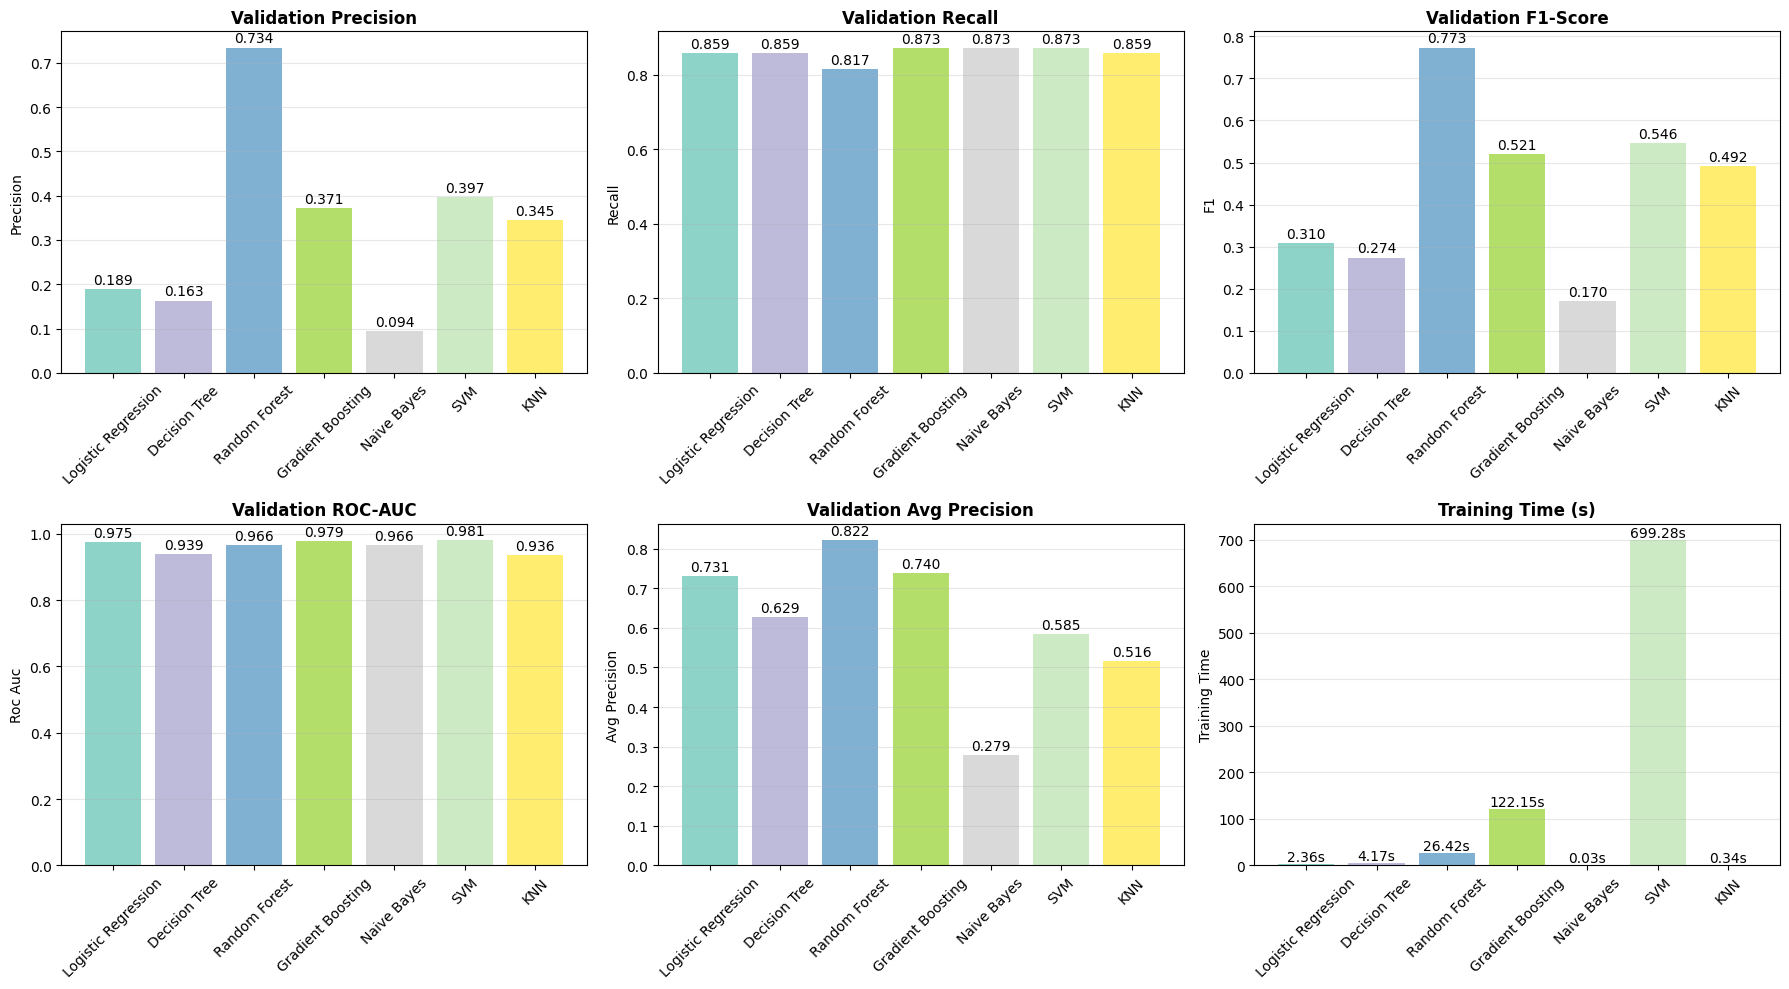

In [6]:
# ============================================================================
# 3. BASELINE MODELS
# ============================================================================

print("\n" + "="*60)
print("BASELINE MODELS TRAINING")
print("="*60)

# Define baseline models
baseline_models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=10),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'Naive Bayes': GaussianNB(),
    'SVM': SVC(probability=True, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

# Train and evaluate baseline models
print("Training baseline models...")
baseline_results = []

for model_name, model in baseline_models.items():
    print(f"\nTraining {model_name}...")

    try:
        metrics, trained_model, predictions, probabilities = evaluate_model(
            model, X_train, y_train, X_val, y_val, model_name
        )
        baseline_results.append(metrics)
        print(f"✓ {model_name} completed - Val F1: {metrics['val_f1']:.4f}, ROC-AUC: {metrics['val_roc_auc']:.4f}")

    except Exception as e:
        print(f" {model_name} failed: {str(e)}")

# Convert results to DataFrame
baseline_df = pd.DataFrame(baseline_results)
print(f"\n✓ {len(baseline_results)} baseline models trained successfully!")

# Display results table
print("\nBaseline Models Performance Summary:")
display_cols = ['model_name', 'val_precision', 'val_recall', 'val_f1', 'val_roc_auc', 'training_time']
display(baseline_df[display_cols].round(4))

# Plot baseline comparison
print("\nBaseline Models Comparison:")
plot_model_comparison(baseline_df)

In [7]:
# ============================================================================
# 4. ADVANCED MODELS (XGBoost, LightGBM)
# ============================================================================

print("\n" + "="*60)
print("ADVANCED MODELS TRAINING")
print("="*60)

# XGBoost model
print("Training XGBoost...")
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    eval_metric='logloss',
    n_jobs=-1
)

xgb_metrics, xgb_trained, xgb_pred, xgb_proba = evaluate_model(
    xgb_model, X_train, y_train, X_val, y_val, "XGBoost"
)
print(f"✓ XGBoost - Val F1: {xgb_metrics['val_f1']:.4f}, ROC-AUC: {xgb_metrics['val_roc_auc']:.4f}")

# LightGBM model
print("\nTraining LightGBM...")
lgb_model = lgb.LGBMClassifier(
    objective='binary',
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

lgb_metrics, lgb_trained, lgb_pred, lgb_proba = evaluate_model(
    lgb_model, X_train, y_train, X_val, y_val, "LightGBM"
)
print(f"✓ LightGBM - Val F1: {lgb_metrics['val_f1']:.4f}, ROC-AUC: {lgb_metrics['val_roc_auc']:.4f}")

# Anomaly Detection with Isolation Forest
print("\nTraining Isolation Forest...")
iso_forest = IsolationForest(contamination=0.1, random_state=42, n_jobs=-1)
iso_forest.fit(X_train)

# Predict anomalies (invert predictions: -1 -> 1, 1 -> 0)
y_val_iso_pred = (iso_forest.predict(X_val) == -1).astype(int)
y_val_iso_scores = -iso_forest.score_samples(X_val)  # Higher scores = more anomalous

iso_metrics = {
    'model_name': 'Isolation Forest',
    'training_time': 0,  # Will be updated
    'val_precision': precision_score(y_val, y_val_iso_pred),
    'val_recall': recall_score(y_val, y_val_iso_pred),
    'val_f1': f1_score(y_val, y_val_iso_pred),
    'val_roc_auc': roc_auc_score(y_val, y_val_iso_scores),
    'val_avg_precision': average_precision_score(y_val, y_val_iso_scores)
}
print(f"✓ Isolation Forest - Val F1: {iso_metrics['val_f1']:.4f}, ROC-AUC: {iso_metrics['val_roc_auc']:.4f}")

# Combine all results
all_results = baseline_results + [xgb_metrics, lgb_metrics, iso_metrics]
all_results_df = pd.DataFrame(all_results)

print(f"\n✓ Total models trained: {len(all_results)}")


ADVANCED MODELS TRAINING
Training XGBoost...
✓ XGBoost - Val F1: 0.5381, ROC-AUC: 0.9770

Training LightGBM...
✓ LightGBM - Val F1: 0.5405, ROC-AUC: 0.9793

Training Isolation Forest...
✓ Isolation Forest - Val F1: 0.2479, ROC-AUC: 0.9596

✓ Total models trained: 10


In [8]:
# ============================================================================
# 5. HYPERPARAMETER TUNING
# ============================================================================

print("\n" + "="*60)
print("HYPERPARAMETER TUNING")
print("="*60)

# Define parameter grids for top performing models
param_grids = {
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42, n_jobs=-1),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [10, 15, 20],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
    },
    'XGBoost': {
        'model': xgb.XGBClassifier(objective='binary:logistic', random_state=42, n_jobs=-1),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [4, 6, 8],
            'learning_rate': [0.05, 0.1, 0.2],
            'subsample': [0.8, 1.0]
        }
    },
    'LightGBM': {
        'model': lgb.LGBMClassifier(objective='binary', random_state=42, n_jobs=-1, verbose=-1),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [4, 6, 8],
            'learning_rate': [0.05, 0.1, 0.2],
            'num_leaves': [31, 50, 70]
        }
    }
}

# Perform hyperparameter tuning
tuned_results = []
tuned_models = {}

for model_name, config in param_grids.items():
    print(f"\nTuning {model_name}...")

    # Use RandomizedSearchCV for efficiency
    search = RandomizedSearchCV(
        config['model'],
        config['params'],
        n_iter=20,  # Number of random combinations to try
        cv=3,       # 3-fold cross-validation
        scoring='f1',
        n_jobs=-1,
        random_state=42,
        verbose=0
    )

    start_time = time.time()
    search.fit(X_train, y_train)
    tuning_time = time.time() - start_time

    # Evaluate best model
    best_model = search.best_estimator_
    metrics, trained_model, predictions, probabilities = evaluate_model(
        best_model, X_train, y_train, X_val, y_val, f"{model_name} (Tuned)"
    )

    metrics['tuning_time'] = tuning_time
    tuned_results.append(metrics)
    tuned_models[model_name] = {
        'model': trained_model,
        'best_params': search.best_params_,
        'cv_score': search.best_score_
    }

    print(f"✓ {model_name} tuned - Val F1: {metrics['val_f1']:.4f}")
    print(f"  Best params: {search.best_params_}")
    print(f"  CV F1 score: {search.best_score_:.4f}")


HYPERPARAMETER TUNING

Tuning Random Forest...
✓ Random Forest tuned - Val F1: 0.7763
  Best params: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20}
  CV F1 score: 0.9956

Tuning XGBoost...
✓ XGBoost tuned - Val F1: 0.7317
  Best params: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.2}
  CV F1 score: 0.9976

Tuning LightGBM...
✓ LightGBM tuned - Val F1: 0.7613
  Best params: {'num_leaves': 50, 'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.2}
  CV F1 score: 0.9978



MODEL COMPARISON AND SELECTION
Final Model Rankings (by Validation F1-Score):


,model_name,val_precision,val_recall,val_f1,val_roc_auc,val_avg_precision
10,Random Forest (Tuned),0.7284,0.8310,0.7763,0.9868,0.8342
2,Random Forest,0.7342,0.8169,0.7733,0.9665,0.8217
12,LightGBM (Tuned),0.7024,0.8310,0.7613,0.9701,0.8379
11,XGBoost (Tuned),0.6452,0.8451,0.7317,0.9759,0.8390
5,SVM,0.3974,0.8732,0.5463,0.9808,0.5851
8,LightGBM,0.3974,0.8451,0.5405,0.9793,0.7961
7,XGBoost,0.3947,0.8451,0.5381,0.9770,0.7757
3,Gradient Boosting,0.3713,0.8732,0.5210,0.9789,0.7396
6,KNN,0.3446,0.8592,0.4919,0.9358,0.5162
0,Logistic Regression,0.1889,0.8592,0.3096,0.9752,0.7310



Final Model Performance Comparison:


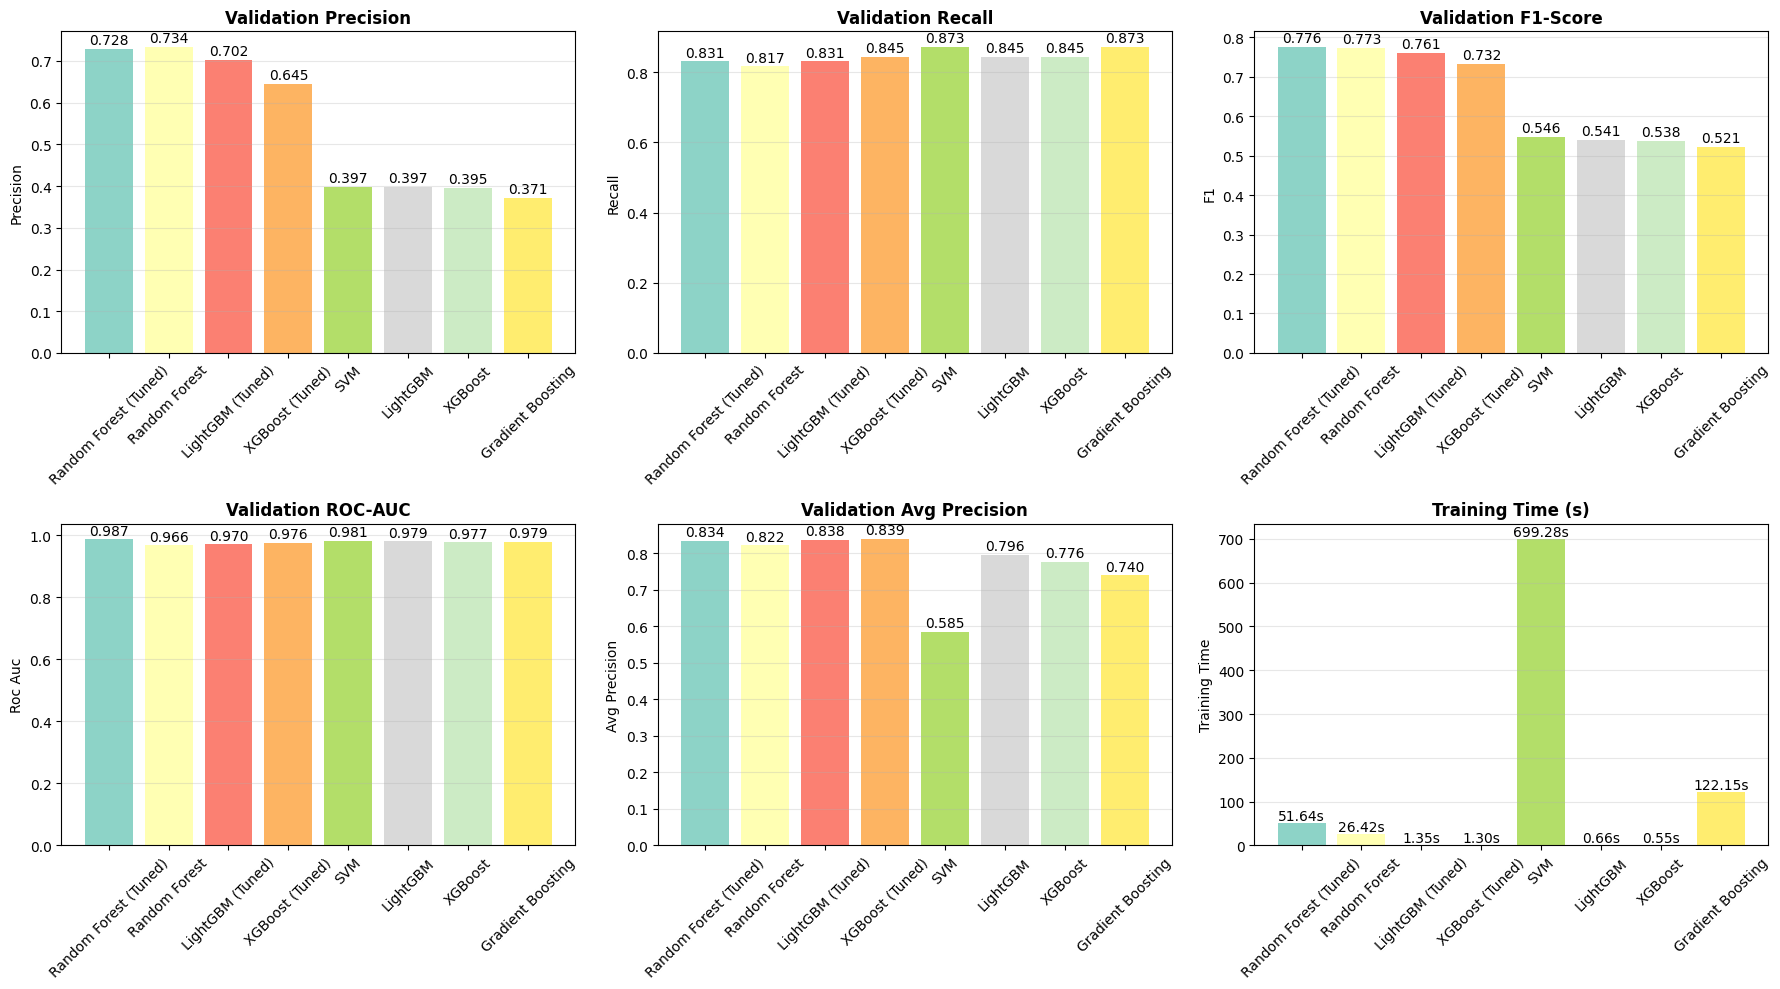


 BEST MODEL: Random Forest (Tuned)
• Validation F1-Score: 0.7763
• Validation ROC-AUC: 0.9868
• Validation Precision: 0.7284
• Validation Recall: 0.8310


In [9]:
# ============================================================================
# 6. MODEL COMPARISON AND SELECTION
# ============================================================================

print("\n" + "="*60)
print("MODEL COMPARISON AND SELECTION")
print("="*60)

# Combine baseline and tuned results
final_results = all_results + tuned_results
final_df = pd.DataFrame(final_results)

# Sort by validation F1 score
final_df_sorted = final_df.sort_values('val_f1', ascending=False)

print("Final Model Rankings (by Validation F1-Score):")
display_cols = ['model_name', 'val_precision', 'val_recall', 'val_f1', 'val_roc_auc', 'val_avg_precision']
display(final_df_sorted[display_cols].round(4))

# Plot final comparison
print("\nFinal Model Performance Comparison:")
plot_model_comparison(final_df_sorted.head(8))  # Top 8 models

# Select best model
best_model_info = final_df_sorted.iloc[0]
best_model_name = best_model_info['model_name']
print(f"\n BEST MODEL: {best_model_name}")
print(f"• Validation F1-Score: {best_model_info['val_f1']:.4f}")
print(f"• Validation ROC-AUC: {best_model_info['val_roc_auc']:.4f}")
print(f"• Validation Precision: {best_model_info['val_precision']:.4f}")
print(f"• Validation Recall: {best_model_info['val_recall']:.4f}")


DETAILED ANALYSIS: Random Forest (Tuned)
Best parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20}

Confusion Matrix:
[[42353    22]
 [   12    59]]


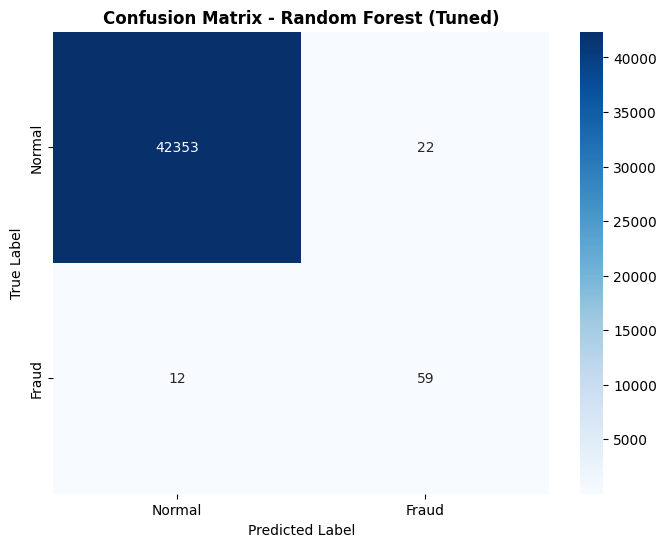


Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     42375
       Fraud       0.73      0.83      0.78        71

    accuracy                           1.00     42446
   macro avg       0.86      0.92      0.89     42446
weighted avg       1.00      1.00      1.00     42446



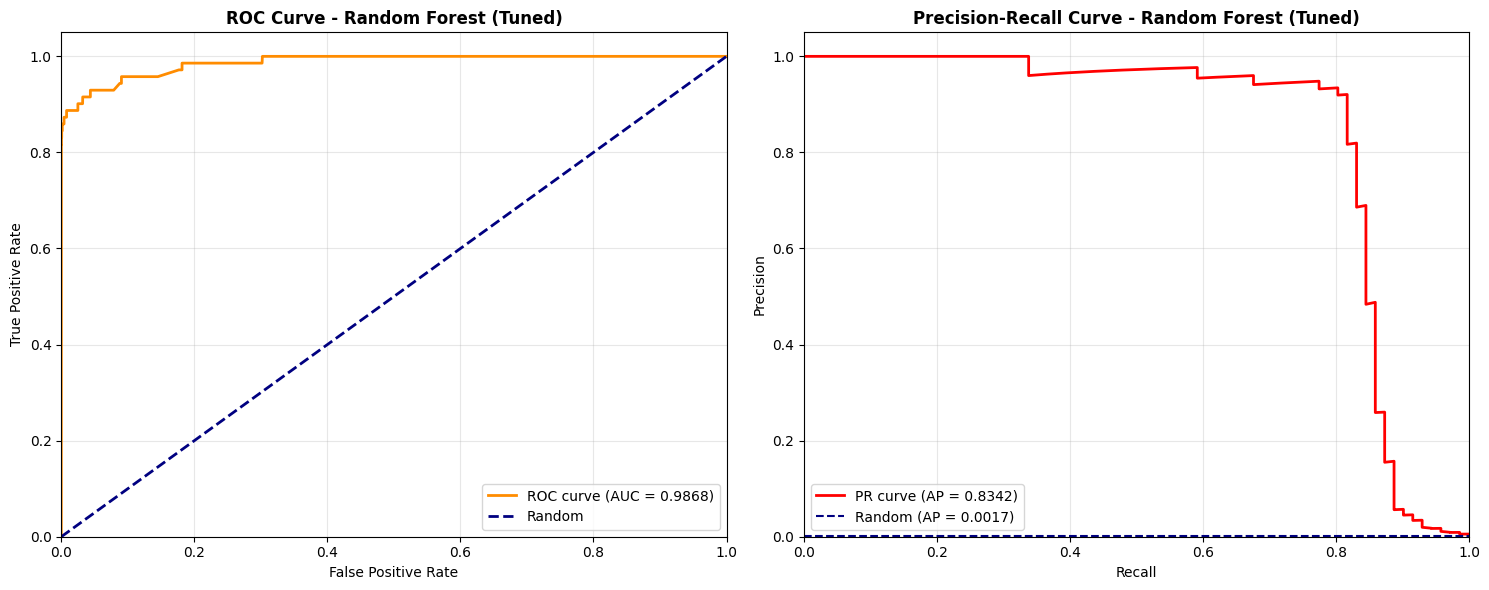


Feature Importance Analysis:

Top 10 Most Important Features:


,feature,importance
1,V14,0.261776
3,V10,0.197319
0,V17,0.143535
4,V12,0.140529
7,V11,0.091271
5,V16,0.048387
2,V3,0.041833
8,V4,0.039765
9,V18,0.018447
6,V7,0.017137


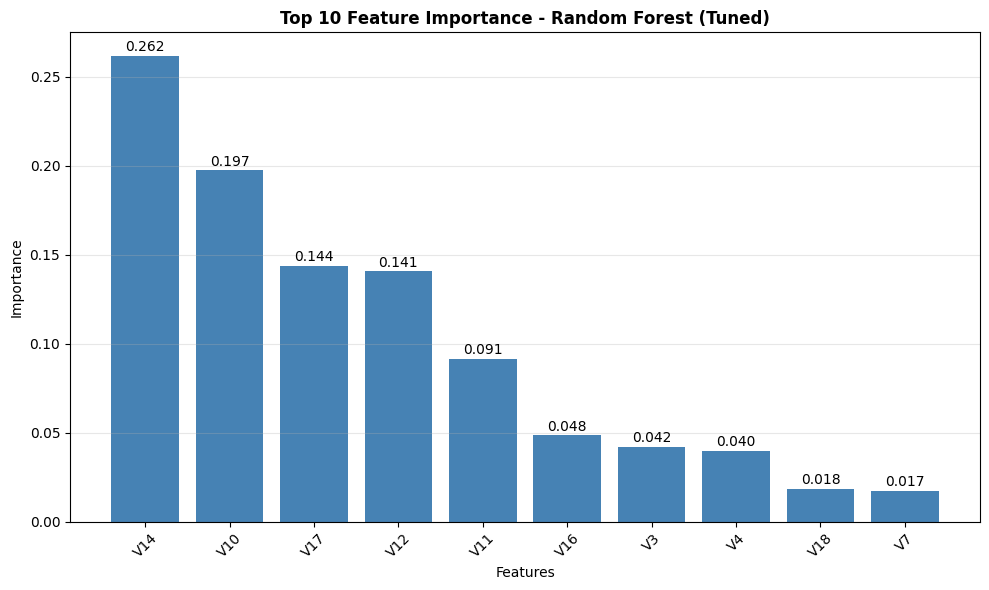

In [10]:
# ============================================================================
# 7. DETAILED ANALYSIS OF BEST MODEL
# ============================================================================

print("\n" + "="*60)
print(f"DETAILED ANALYSIS: {best_model_name}")
print("="*60)

# Get the best trained model
if "(Tuned)" in best_model_name:
    base_name = best_model_name.replace(" (Tuned)", "")
    best_trained_model = tuned_models[base_name]['model']
    print(f"Best parameters: {tuned_models[base_name]['best_params']}")
else:
    # Retrain the best baseline model
    best_trained_model = baseline_models[best_model_name]
    best_trained_model.fit(X_train, y_train)

# Predictions for detailed analysis
y_val_pred_best = best_trained_model.predict(X_val)
y_val_proba_best = best_trained_model.predict_proba(X_val)[:, 1]

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_val, y_val_pred_best)
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'])
plt.title(f'Confusion Matrix - {best_model_name}', fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred_best, target_names=['Normal', 'Fraud']))

# ROC Curve and Precision-Recall Curve
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_val_proba_best)
roc_auc = roc_auc_score(y_val, y_val_proba_best)

axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title(f'ROC Curve - {best_model_name}', fontweight='bold')
axes[0].legend(loc="lower right")
axes[0].grid(True, alpha=0.3)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_val, y_val_proba_best)
avg_precision = average_precision_score(y_val, y_val_proba_best)

axes[1].plot(recall, precision, color='red', lw=2, label=f'PR curve (AP = {avg_precision:.4f})')
axes[1].axhline(y=y_val.mean(), color='navy', linestyle='--', label=f'Random (AP = {y_val.mean():.4f})')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title(f'Precision-Recall Curve - {best_model_name}', fontweight='bold')
axes[1].legend(loc="lower left")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Feature Importance (if available)
if hasattr(best_trained_model, 'feature_importances_'):
    print("\nFeature Importance Analysis:")

    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': best_trained_model.feature_importances_
    }).sort_values('importance', ascending=False)

    print("\nTop 10 Most Important Features:")
    display(feature_importance.head(10))

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    top_features = feature_importance.head(10)
    bars = plt.bar(range(len(top_features)), top_features['importance'], color='steelblue')
    plt.title(f'Top 10 Feature Importance - {best_model_name}', fontweight='bold')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.xticks(range(len(top_features)), top_features['feature'], rotation=45)

    # Add value labels
    for bar, importance in zip(bars, top_features['importance']):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                f'{importance:.3f}', ha='center', va='bottom')

    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()

In [11]:
# ============================================================================
# 8. BUSINESS IMPACT ANALYSIS
# ============================================================================

print("\n" + "="*60)
print("BUSINESS IMPACT ANALYSIS")
print("="*60)

# Define business costs (example values)
COST_FALSE_POSITIVE = 50    # Cost of blocking a legitimate transaction
COST_FALSE_NEGATIVE = 500   # Cost of missing a fraudulent transaction
AVERAGE_FRAUD_AMOUNT = 100  # Average amount in fraudulent transactions

# Calculate business metrics
tn, fp, fn, tp = cm.ravel()

total_cost_fp = fp * COST_FALSE_POSITIVE
total_cost_fn = fn * COST_FALSE_NEGATIVE
total_fraud_prevented = tp * AVERAGE_FRAUD_AMOUNT
total_cost = total_cost_fp + total_cost_fn
total_savings = total_fraud_prevented - total_cost

print(f"Business Impact Analysis for {best_model_name}:")
print(f"• True Positives (Frauds Caught): {tp:,}")
print(f"• False Positives (Legit Blocked): {fp:,}")
print(f"• False Negatives (Frauds Missed): {fn:,}")
print(f"• True Negatives (Legit Approved): {tn:,}")

print(f"\nCost Analysis:")
print(f"• Cost of False Positives: ${total_cost_fp:,}")
print(f"• Cost of False Negatives: ${total_cost_fn:,}")
print(f"• Total Operational Cost: ${total_cost:,}")
print(f"• Fraud Amount Prevented: ${total_fraud_prevented:,}")
print(f"• Net Savings: ${total_savings:,}")

# Precision-Recall Trade-off Analysis
print(f"\nPrecision-Recall Trade-off:")
print(f"• High Precision = Fewer False Alarms = Better Customer Experience")
print(f"• High Recall = Catch More Frauds = Less Financial Loss")
print(f"• Current Model: {best_model_info['val_precision']:.1%} Precision, {best_model_info['val_recall']:.1%} Recall")


BUSINESS IMPACT ANALYSIS
Business Impact Analysis for Random Forest (Tuned):
• True Positives (Frauds Caught): 59
• False Positives (Legit Blocked): 22
• False Negatives (Frauds Missed): 12
• True Negatives (Legit Approved): 42,353

Cost Analysis:
• Cost of False Positives: $1,100
• Cost of False Negatives: $6,000
• Total Operational Cost: $7,100
• Fraud Amount Prevented: $5,900
• Net Savings: $-1,200

Precision-Recall Trade-off:
• High Precision = Fewer False Alarms = Better Customer Experience
• High Recall = Catch More Frauds = Less Financial Loss
• Current Model: 72.8% Precision, 83.1% Recall


In [12]:
# ============================================================================
# 9. MODEL PERFORMANCE SUMMARY
# ============================================================================

print("\n" + "="*60)
print("MODEL PERFORMANCE SUMMARY")
print("="*60)

print(" FINAL RESULTS SUMMARY:")
print(f"• Best Model: {best_model_name}")
print(f"• Validation Accuracy: {best_model_info['val_accuracy']:.4f}")
print(f"• Validation Precision: {best_model_info['val_precision']:.4f}")
print(f"• Validation Recall: {best_model_info['val_recall']:.4f}")
print(f"• Validation F1-Score: {best_model_info['val_f1']:.4f}")
print(f"• Validation ROC-AUC: {best_model_info['val_roc_auc']:.4f}")

print(f"\n KEY INSIGHTS:")
print(f"• Fraud Detection Rate: {best_model_info['val_recall']:.1%}")
print(f"• False Alarm Rate: {(1-best_model_info['val_precision']):.1%}")
print(f"• Model Confidence: ROC-AUC of {best_model_info['val_roc_auc']:.3f}")

print(f"\n BUSINESS VALUE:")
print(f"• Net Cost Savings: ${total_savings:,}")
print(f"• Fraud Prevention: ${total_fraud_prevented:,}")
print(f"• Model Efficiency: {total_savings/total_fraud_prevented:.1%} of prevented fraud is net profit")

print(f"\n NEXT STEPS:")
print("1. Test best model on held-out test set")
print("2. Implement deep learning model for comparison")
print("3. Deploy model to production")
print("4. Set up monitoring and retraining pipeline")

# Save best model for deployment
print(f"\n SAVING BEST MODEL...")
model_artifacts = {
    'best_model': best_trained_model,
    'model_name': best_model_name,
    'feature_names': feature_names,
    'performance_metrics': dict(best_model_info),
    'confusion_matrix': cm.tolist(),
    'business_impact': {
        'total_savings': total_savings,
        'fraud_prevented': total_fraud_prevented,
        'operational_cost': total_cost
    }
}

print(" MODEL TRAINING COMPLETED SUCCESSFULLY!")
print(f"Ready for deep learning comparison and deployment!")


MODEL PERFORMANCE SUMMARY
 FINAL RESULTS SUMMARY:
• Best Model: Random Forest (Tuned)
• Validation Accuracy: 0.9992
• Validation Precision: 0.7284
• Validation Recall: 0.8310
• Validation F1-Score: 0.7763
• Validation ROC-AUC: 0.9868

 KEY INSIGHTS:
• Fraud Detection Rate: 83.1%
• False Alarm Rate: 27.2%
• Model Confidence: ROC-AUC of 0.987

 BUSINESS VALUE:
• Net Cost Savings: $-1,200
• Fraud Prevention: $5,900
• Model Efficiency: -20.3% of prevented fraud is net profit

 NEXT STEPS:
1. Test best model on held-out test set
2. Implement deep learning model for comparison
3. Deploy model to production
4. Set up monitoring and retraining pipeline

 SAVING BEST MODEL...
 MODEL TRAINING COMPLETED SUCCESSFULLY!
Ready for deep learning comparison and deployment!
